The purpose of this script is to count penalties by zone for each team.

In [1]:
import pandas as pd
from pylab import *
%matplotlib inline

from scrapenhl2.scrape import team_info, schedules, autoupdate, teams
import scrapenhl2.manipulate.manipulate as manip
import scrapenhl2.manipulate.add_onice_players as onice
# autoupdate.autoupdate()  # uncomment this to update data

We can repurpose some code targeted at faceoffs for penalties. We'll have to also create a new category for penalties without a zone (because of human error, or because it doesn't apply). We'll also limit the search to counts of 5v5 penalties.

In [2]:
dflst = []
season = 2017
for team in schedules.get_teams_in_season(season):
    pbp = teams.get_team_pbp(season, team)

    directions = manip.get_directions_for_xy_for_season(season, team)
    penalties = manip.filter_for_five_on_five(manip.filter_for_event_types(pbp, 'Penalty'))
    penalties = penalties[['Game', 'Team', 'Time', 'X', 'Y']].assign(Season=season)
    pbp_zones = manip.infer_zones_for_events(penalties, directions, 'X', 'Y', 'Time', focus_team=team,
                                             faceoffs=False) \
        .rename(columns={'EventLoc': 'Zone'})
    zone_counts = pbp_zones.assign(Team2 = pbp_zones.Team.apply(lambda x: 'PTake' if x == team else 'PDraw'),
                                  Team=team) \
        .drop({'Game', 'Time', 'X', 'Y', 'Season'}, axis=1) \
        .assign(Count=1) \
        .groupby(['Team', 'Zone', 'Team2'], as_index='False') \
        .count() \
        .pivot_table(index=['Team', 'Zone'], columns='Team2', values='Count') \
        .reset_index() \
        .fillna(0)
    dflst.append(zone_counts)
df = pd.concat(dflst)
df.head()

Team2,Team,Zone,PDraw,PTake
0,1,D,26.0,31.0
1,1,N,4.0,10.0
2,1,O,23.0,20.0
3,1,Zone N/A,4.0,4.0
0,2,D,25.0,29.0


In [3]:
# Get X coords for each graph
xs = df[['Team', 'PDraw', 'PTake']].drop_duplicates() \
    .groupby('Team', as_index=False) \
    .sum()
ranks = xs.drop('Team', axis=1) \
    .rank(method='first') \
    .rename(columns={'PDraw': 'DrawX', 'PTake': 'TakeX'})
xs = pd.concat([xs, ranks], axis=1)
xs.loc[:, 'TeamName'] = xs.Team.apply(lambda x: team_info.team_as_str(x))

joined = df.merge(xs[['Team', 'DrawX', 'TakeX']], how='inner', on='Team')

# Add bottoms for stacked bars
joined = joined.sort_values(['Team', 'Zone'])
joined.loc[:, 'BottomDraw'] = joined[['PDraw', 'Team']].groupby('Team').cumsum().PDraw
joined.loc[:, 'BottomDraw'] = joined.BottomDraw - joined.PDraw
joined.loc[:, 'BottomTake'] = joined[['PTake', 'Team']].groupby('Team').cumsum().PTake
joined.loc[:, 'BottomTake'] = joined.BottomTake - joined.PTake

joined = joined.fillna(0)
joined.head()

Team2,Team,Zone,PDraw,PTake,DrawX,TakeX,BottomDraw,BottomTake
0,1,D,26.0,31.0,9.0,18.0,0.0,0.0
1,1,N,4.0,10.0,9.0,18.0,26.0,31.0
2,1,O,23.0,20.0,9.0,18.0,30.0,41.0
3,1,Zone N/A,4.0,4.0,9.0,18.0,53.0,61.0
4,2,D,25.0,29.0,14.0,12.0,0.0,0.0


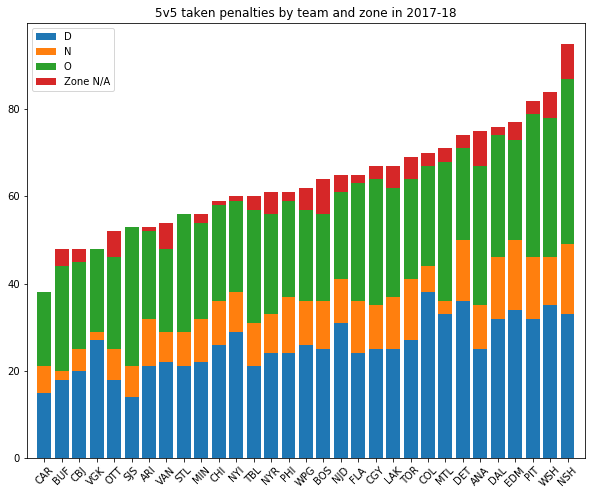

In [4]:
fig = figure(figsize=(10, 8))

ptype = 'Take'
for zone in ['D', 'N', 'O', 'Zone N/A']:
    temp = joined.query('Zone == "{0:s}"'.format(zone))
    col1 = ptype + 'X'
    col2 = 'P' + str(ptype)
    col3 = 'Bottom' + str(ptype)
    bar(left=temp[col1].values, height=temp[col2].values, bottom=temp[col3].values, label=zone)
title('5v5 {0:s}n penalties by team and zone in {1:d}-{2:s}'.format(ptype.lower(), season, str(season+1)[2:]))

xs = xs.sort_values(ptype + 'X')
xcol = ptype + 'X'

xticks(xs[xcol].values, xs.TeamName.values, rotation=45)
xlim(xs[xcol].min() - 1, xs[xcol].max() + 1)
legend(loc=2)

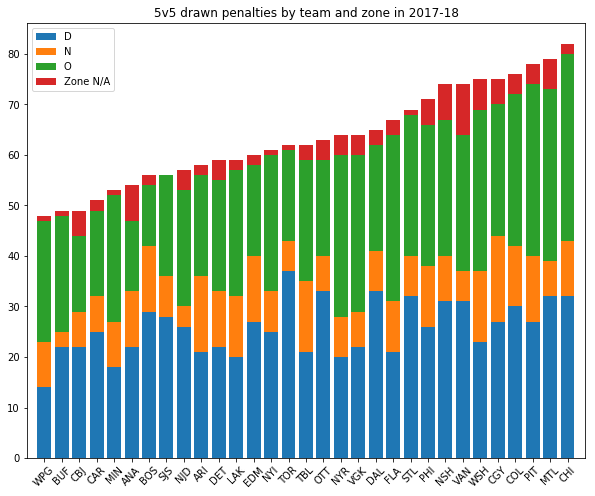

In [5]:
fig = figure(figsize=(10, 8))

ptype = 'Draw'
for zone in ['D', 'N', 'O', 'Zone N/A']:
    temp = joined.query('Zone == "{0:s}"'.format(zone))
    col1 = ptype + 'X'
    col2 = 'P' + str(ptype)
    col3 = 'Bottom' + str(ptype)
    bar(left=temp[col1].values, height=temp[col2].values, bottom=temp[col3].values, label=zone)
title('5v5 {0:s}n penalties by team and zone in {1:d}-{2:s}'.format(ptype.lower(), season, str(season+1)[2:]))

xs = xs.sort_values(ptype + 'X')
xcol = ptype + 'X'

xticks(xs[xcol].values, xs.TeamName.values, rotation=45)
xlim(xs[xcol].min() - 1, xs[xcol].max() + 1)
legend(loc=2)